# 1.导包

In [781]:
import os

#数据处理
import pandas as pd
import numpy as np
import random
import sklearn.preprocessing as preprocessing
from scipy.special import boxcox1p

#可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import (GradientBoostingClassifier, GradientBoostingRegressor, 
                              RandomForestClassifier, RandomForestRegressor)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve

In [782]:
# 如果为True，则对训练集合进行处理；否则对测试集合进行处理
flag = False

# 2.数据载入、对齐、排序

In [783]:
data = pd.read_pickle('data/round1_train1')

if(flag is False):
    data_test = pd.read_pickle('data/round1_test1')

In [784]:
# 给test数据拼接一个f26特征
if(flag is False):
    data_test = pd.concat([data_test,pd.Series([0] * len(data_test))], axis = 1)
    data_test = data_test.rename({0:'f26'},axis = 'columns')

# 给train数据按时间排序
data.sort_values(['f16'],inplace = True)
data.reset_index(drop=True,inplace = True)

# 3.特征转换、衍生
## 3.1离散数据
### 3.1.1将出现次数少的值合并到统一类别中
- f6：将10（456）、2（347）、1（85）、11（21）、0（12）、17（1）、16（1）这几个取值单独拉出一个类。
- f9：将8（449）、7（245）、0（123）、6（116）、5（63）、4（33）3（11）、2（5）、1（1）这几个取值单独拉出一个类。
- f20：将23（353）、4（266）、2（87）、3（80）、1（20）、0（7）、25（4）这几个取值单独拉出一个类。
- f22：将5002（477）、5020（357）、5000（81）、5019（70）、5001（60）、4999（7）这几个取值单独拉出一个类。

In [785]:
# TODO

### 3.1.2onehot/dummy-trap
- 如果类别特征本身有顺序（例：优秀、良好、合格、不合格），那么可以保留单列自然数编码。如果类别特征没有明显的顺序（例：红、黄、蓝）则使用one-hot。
- f6广告商品的价格等级、f9广告商品被展示次数的等级、f11用户的预测性别编号、f12用户的预测年龄等级、f13用户的预测职业编号、f14用户的星级编号
- f7、f8、f17、f20、f22不确定
- sklearn.preprocessing.OneHotEncoder()

#### 3.1.2.1f11

In [786]:
def onehot_f11(data):
    temp = pd.get_dummies(data['f11'])  
    temp = temp.rename({0.0:'f11:woman',1.0:'f11:man',2.0:'f11:family',3.0:'f11:other'},axis = 'columns')
    return pd.concat([data.loc[:,'f0':'f11'],temp,data.loc[:,'f12':'f26']], axis = 1)

data = onehot_f11(data)
if(flag is False):
    data_test = onehot_f11(data_test)

#### 3.1.2.2f13

In [787]:
def onehot_f13(data):
    temp = pd.get_dummies(data['f13'])  
    temp = temp.rename({2002.0:'f13:2002.0',2003.0:'f13:2003.0',2004.0:'f13:2004.0',2005.0:'f13:2005.0'},axis = 'columns')
    return pd.concat([data.loc[:,'f0':'f13'],temp,data.loc[:,'f14':'f26']], axis = 1)

data = onehot_f13(data)
if(flag is False):
    data_test = onehot_f13(data_test)

#### 3.1.2.3f2

In [788]:
def split_f2(data):
    # 切分
    data = pd.concat([data.loc[:,'f0':'f2'],data['f2'].astype(np.str).str.split(';', expand=True),data.loc[:,'f3':'f26']], axis = 1)
    data.rename({0:'f2:1',1:'f2:2',2:'f2:3'}, axis='columns',inplace = True)
    print(data.columns)
    # 类型转换
    data['f2:3'].fillna('-1',inplace = True)
    data['f2:1'] = data['f2:1'].astype('int')
    data['f2:2'] =data['f2:2'].astype('int')
    data['f2:3'] = data['f2:3'].astype('int')

    # 丢弃f2:1，对f2:2、f2:3进行onehot编码
    temp = pd.get_dummies(data['f2:2'],prefix = 'f2:2')  
    data = pd.concat([data.loc[:,'f0':'f2:2'],temp,data.loc[:,'f2:3':'f26']], axis = 1)

    temp = pd.get_dummies(data['f2:3'],prefix = 'f2:3')  
    return pd.concat([data.loc[:,'f0':'f2:3'],temp,data.loc[:,'f3':'f26']], axis = 1)

data = split_f2(data)
if(flag is False):
    data_test = split_f2(data_test)

Index(['f0', 'f1', 'f2', 'f2:1', 'f2:2', 'f2:3', 'f3', 'f4', 'f5', 'f6', 'f7',
       'f8', 'f9', 'f10', 'f11', 'f11:woman', 'f11:man', 'f11:family',
       'f11:other', 'f12', 'f13', 'f13:2002.0', 'f13:2003.0', 'f13:2004.0',
       'f13:2005.0', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26'],
      dtype='object')
Index(['f0', 'f1', 'f2', 'f2:1', 'f2:2', 'f2:3', 'f3', 'f4', 'f5', 'f6', 'f7',
       'f8', 'f9', 'f10', 'f11', 'f11:woman', 'f11:man', 'f11:family',
       'f11:other', 'f12', 'f13', 'f13:2002.0', 'f13:2003.0', 'f13:2004.0',
       'f13:2005.0', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21',
       'f22', 'f23', 'f24', 'f25', 'f26'],
      dtype='object')


#### 3.1.2.4f5

In [789]:
# def onehot_f5(data):
#     temp = pd.get_dummies(data['f5'],prefix='f5')  
#     return pd.concat([data.loc[:,'f0':'f5'],temp,data.loc[:,'f6':'f26']], axis = 1)

# data = onehot_f5(data)
# if(flag is False):
#     data_test = onehot_f5(data_test)

In [790]:
# data = pd.concat([data.loc[:,'f0':'f5_5.326000431362992e+18'],pd.Series([np.nan] * len(data)),data.loc[:,'f5_5.727554123450503e+18':'f26']],axis = 1) 

In [791]:
# data = data.rename({0:'f5_5.559622052853629e+18'},axis = 'columns')

- 将f11、f13进行onehot编码后，xgboost的验证集loss由0.084306减小到0.084273
- 将f2;2用onehot表示后，xgboost的验证集loss由0.0775减小到0.07373
- 将f5用onehot表示后，xgboost的验证集loss由0.086977提高到0.087148，没用

### 3.1.3自然数编码
- 消耗内存小，训练时间快，但是相比one-hot特征的质量不高，含了一个假设：不同的类别之间，存在一种顺序关系。
- pd.Factorize()
- sklearn.LabelEncoder()

### 3.1.4聚类编码
- 和独热编码相比，聚类编码试图充分利用每一列0与1的信息表达能力。聚类编码时一般需要特定的专业知识（domain knowledge），例如ZIP码可以根据精确度分层为ZIP3、ZIP4、ZIP5、ZIP6，然后按层次进行编码。

- （我个人尚未使用过这种方法，仅在读论文的时候看到了类似的思路，所以暂时不知道对于各种算法而言效果如何。）


## 3.2连续数据
### 3.2.1scaling：分布太宽，做一下scaling，如：标准化、归一化

In [792]:
# scaling
# def scaling(data):
#     for i in range(0,8):
#         data['f12'] = data['f12'].replace(1000. + i,0 + i)
#     for i in range(0,11):
#         data['f14'] = data['f14'].replace(3000. + i,0 + i)
#     for i in range(0,20):
#         data['f17'] = data['f17'].replace(4001. + i,0 + i)
#     for i in range(0,22):
#         data['f22'] = data['f22'].replace(4999. + i,0 + i)
#         return data

# data = scaling(data)
# if(flag is False):
#     data_test = scaling(data_test)

- 将f112、f14、f17、f22进行范围缩放后，xgboost的验证集loss由0.0775没变，没用。

### 3.2.2正态化：对偏度大于0.75的数值特征（长尾分布）
- 用log1p函数进行转化使其更加服从高斯分布
np.log1p(train.SalePrice)
- Box-Cox变换

In [793]:
# f7:2 f8:2.5 f9:5 f20:1.5
# def boxcox(data):
#     data['f7'] = boxcox1p(data['f7'],2)
#     data['f8'] = boxcox1p(data['f8'],2.5)
#     data['f9'] = boxcox1p(data['f9'],5)
#     data['f20'] = boxcox1p(data['f20'],1.5)
#     return data

# data = boxcox(data)
# if(flag is False):
#     data_test = boxcox(data_test)

### 3.2.3Binning：连续变量离散化
- 只有在了解属性的领域知识的基础，确定属性能够划分成简洁的范围时分箱才有意义，即所有的数值落入一个分区时能够呈现出共同的特征。
- 当不想让模型总是尝试区分值之间是否太近时，分区可以避免出现过拟合。

- 正态化后，xgboost的验证集loss不变，没用

### 3.2.4时间数据的转换

In [794]:
def transform_f16(data):
    now = pd.to_datetime(data['f16'],unit='s',utc = True)
    
    size = len(data)
    # year = pd.Series([-1] * 477303)
    # month = pd.Series([-1] * 477303)
    day = pd.Series([-1] * size)
    hour = pd.Series([-1] * size)
    minute = pd.Series([-1] * size)
    second = pd.Series([-1] * size)
    dayofweek = pd.Series([-1] * size)
    dayofyear = pd.Series([-1] * size)

    for i in range(len(data['f16'])):
    #     year[i] = data['f16'][0].year
    #     month[i] = data['f16'][0].month
        day[i] = now[i].day
        hour[i] = now[i].hour
        minute[i] = now[i].minute
        second[i] = now[i].second
        dayofweek[i] = now[i].dayofweek
        dayofyear[i] = now[i].dayofyear
    data = pd.concat([data.loc[:,'f0':'f16'],day,hour,minute,second,dayofweek,dayofyear,data.loc[:,'f17':'f26']], axis = 1)
    data.rename({'f26':'label'}, axis='columns',inplace = True)
    data.rename({0:'f16:day',1:'f16:hour',2:'f16:minute',3:'f16:second',4:'f16:dayofweek',5:'f16:dayofyear'}, axis='columns',inplace = True)
    return data

data = transform_f16(data)
if(flag is False):
    data_test = transform_f16(data_test)

- 转换时间f16为多个特征并删除特征f16后，xgboost的验证集loss较明显的降低
- 加入dayofweek特征后，xgboost的验证集loss没变，没用

## 3.3高势集数据
### 3.3.1拆分题目中的属性（f2、f3、f18）

### 3.3.3高势集类别（High Categorical）进行经验贝叶斯转换成数值feature

In [795]:
# TODO

### 3.3.4平均数编码
- 平均数编码（mean encoding），针对高基数类别特征的有监督编码。当一个类别特征列包括了极多不同类别时（如家庭地址，动辄上万）时，可以采用。优点：和独热编码相比，节省内存、减少算法计算时间、有效增强模型表现。

- 将f2属性拆分成三个子属性后，xgboost的验证集loss不变，没用

# 4.特征组合
## 4.1转化率
### 4.1.1单特征转化率

In [796]:
data_combination = pd.DataFrame()
data_combination_test = pd.DataFrame()

In [797]:
def get_single_ratio_temp(data,i,name):
    temp = data[data['f16:day'] < i + 17].groupby([name]).apply(lambda x:x['label'].sum()/len(x))  # 前n天出现商品的转化率=
    return data[data['f16:day'] == i + 17][name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

def get_single_ratio(name):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_single_ratio_temp(data,i,name)
        temp = temp.append(now)
    return temp

def get_single_ratio_test(dataall,data,name):
    temp = dataall.groupby([name]).apply(lambda x:x['label'].sum()/len(x))  # 前n天出现商品的转化率=
    return data[name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

In [798]:
if(not os.path.exists('data/myfeature/single_ratio') or not os.path.exists('data/myfeature/single_ratio_test')):
    for feature in ['f1','f4','f5','f10','f19']:
        data_combination = pd.concat([data_combination,get_single_ratio(feature).rename(feature + '-ratio')],axis = 1)
        if(flag is False):
            data_combination_test = pd.concat([data_combination_test,get_single_ratio_test(data,data_test,feature).rename(feature + '-ratio')], axis = 1)
    
    data_combination.to_pickle('data/myfeature/single_ratio')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/single_ratio_test')
else:
    data_combination = pd.read_pickle('data/myfeature/single_ratio')
    data_combination_test = pd.read_pickle('data/myfeature/single_ratio_test')

- 将f19进行转换为点击概率后，xgboost的验证集loss由0.084273减小到0.080542
- 将f1进行转换为点击概率后，xgboost的验证集loss由0.080542减小到0.0775
- 将f5进行转换为点击概率后，lgb的验证集loss由0.08287减小到0.08221 
- 将f10进行转换为点击概率后，lgb的验证集loss由0.08221减小到0.0821587

### 4.1.2组合特征

In [799]:
def get_two_ratio_temp(data,i,first,second):
    # 当前天若干天
    temp = data[data['f16:day'] < i + 17].groupby([first,second]).apply(lambda x:x['label'].sum()/len(x))  # 前n天出现商品的转化率=
    # 当前天
    return data[data['f16:day'] == i + 17].apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

def get_two_ratio(data,first,second):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_two_ratio_temp(data,i,first,second)
        temp = temp.append(now)
    return temp

In [800]:
def get_two_ratio_test(dataall,data,first,second):
    # dataall是训练集，data是待处理的测试集
    temp = dataall.groupby([first,second]).apply(lambda x:x['label'].sum()/len(x))  # 前n天出现商品的转化率=
    return data.apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

In [801]:
features = ['f1','f4','f5','f10','f19']
if(not os.path.exists('data/myfeature/double_ratio') or not os.path.exists('data/myfeature/double_ratio_test')):
    for i in range(len(features)):
        for j in range(i + 1,len(features)):
            data_combination = pd.concat([data_combination,get_two_ratio(data,features[i],features[j]).rename(features[i] + '-' + features[j] + '-ratio')],axis = 1)
            if(flag is False):
                data_combination_test = pd.concat([data_combination_test,get_two_ratio_test(data,data_test,features[i],features[j]).rename(features[i] + '-' + features[j] + '-ratio')], axis = 1)
    data_combination.to_pickle('data/myfeature/double_ratio')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/double_ratio_test')
else:
    data_combination = pd.read_pickle('data/myfeature/double_ratio')
    data_combination_test = pd.read_pickle('data/myfeature/double_ratio_test')

In [802]:
# 舍弃全是-1没有任何信息的
data_combination_test = data_combination_test.drop(['f1-f10-ratio','f1-f19-ratio','f4-f10-ratio','f5-f10-ratio','f10-f19-ratio'],axis = 1)
data_combination = data_combination.drop(['f1-f10-ratio','f1-f19-ratio','f4-f10-ratio','f5-f10-ratio','f10-f19-ratio'],axis = 1)

- 加上f1-f10-label、f1-f4-label、f1-f5-label、f1-f19-label后，lbg的logloss从0.082215下降到0.0820568
- 加上f4-f5-label、f4-f10-label、f4-f19-label、f5-f10-label、f5-f19-label、f10-f19后，lbg的logloss从0.0820568下降到0.0819415

## 4.2购买次数
### 4.2.1单特征购买次数

In [803]:
def get_single_count_temp(data,i,name):
    temp = data[data['f16:day'] < i + 17].groupby([name]).apply(lambda x:x['label'].sum())  # 前n天出现商品的转化率=
    return data[data['f16:day'] == i + 17][name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

def get_single_count(name):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_single_count_temp(data,i,name)
        temp = temp.append(now)
    return temp

In [804]:
def get_single_count_test(dataall,data,name):
    temp = dataall.groupby([name]).apply(lambda x:x['label'].sum())  # 前n天出现商品的转化率=
    return data[name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

In [805]:
features = ['f1','f4','f5','f10','f19']
if(not os.path.exists('data/myfeature/single_count') or not os.path.exists('data/myfeature/single_count_test')):
    for feature in features:
        data_combination = pd.concat([data_combination,get_single_count(feature).rename(feature + '-count')],axis = 1)
        if(flag is False):
            data_combination_test = pd.concat([data_combination_test,get_single_count_test(data,data_test,feature).rename(feature + '-count')], axis = 1)
    
    data_combination.to_pickle('data/myfeature/single_count')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/single_count_test')
else:
    data_combination = pd.read_pickle('data/myfeature/single_count')
    data_combination_test = pd.read_pickle('data/myfeature/single_count_test')

### 4.2.2组合特征购买次数

In [806]:
def get_two_count_temp(data,i,first,second):
    # 当前天若干天
    temp = data[data['f16:day'] < i + 17].groupby([first,second]).apply(lambda x:x['label'].sum())  # 前n天出现商品的转化率=
    # 当前天
    return data[data['f16:day'] == i + 17].apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

def get_two_count(data,first,second):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_two_count_temp(data,i,first,second)
        temp = temp.append(now)
    return temp

In [807]:
def get_two_count_test(dataall,data,first,second):
    # dataall是训练集，data是待处理的测试集
    temp = dataall.groupby([first,second]).apply(lambda x:x['label'].sum())  # 前n天出现商品的转化率=
    return data.apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

In [808]:
features = ['f1','f4','f5','f10','f19']
if(not os.path.exists('data/myfeature/double_count') or not os.path.exists('data/myfeature/double_count_test')):
    for i in range(len(features)):
        for j in range(i + 1,len(features)):
            data_combination = pd.concat([data_combination,get_two_count(data,features[i],features[j]).rename(features[i] + '-' + features[j] + '-count')],axis = 1)
            if(flag is False):
                data_combination_test = pd.concat([data_combination_test,get_two_count_test(data,data_test,features[i],features[j]).rename(features[i] + '-' + features[j] + '-count')], axis = 1)
    
    data_combination.to_pickle('data/myfeature/double_count')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/double_count_test')
else:
    data_combination = pd.read_pickle('data/myfeature/double_count')
    data_combination_test = pd.read_pickle('data/myfeature/double_count_test')

In [809]:
# 舍弃全是-1没有任何信息的
data_combination_test = data_combination_test.drop(['f1-f10-count','f1-f19-count','f4-f10-count','f5-f10-count','f10-f19-count'],axis = 1)
data_combination = data_combination.drop(['f1-f10-count','f1-f19-count','f4-f10-count','f5-f10-count','f10-f19-count'],axis = 1)

## 4.3浏览广告次数
### 4.3.1单特征浏览广告次数

In [810]:
def get_single_browse_count_temp(data,i,name):
    temp = data[data['f16:day'] < i + 17].groupby([name]).apply(lambda x:len(x))  # 前n天出现商品的转化率=
    return data[data['f16:day'] == i + 17][name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

def get_single_browse_count(name):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_single_browse_count_temp(data,i,name)
        temp = temp.append(now)
    return temp

In [811]:
def get_single_browse_count_test(dataall,data,name):
    temp = dataall.groupby([name]).apply(lambda x:len(x))  # 前n天出现商品的转化率=
    return data[name].apply(lambda x,temp:temp[x] if x in temp else -1,args = (temp,))

In [812]:
features = ['f1','f4','f5','f10','f19']
if(not os.path.exists('data/myfeature/single_browse_count') or not os.path.exists('data/myfeature/single_browse_count_test')):
    for feature in features:
        data_combination = pd.concat([data_combination,get_single_browse_count(feature).rename(feature + '-browse-count')],axis = 1)
        if(flag is False):
            data_combination_test = pd.concat([data_combination_test,get_single_browse_count_test(data,data_test,feature).rename(feature + '-browse-count')], axis = 1)
    
    data_combination.to_pickle('data/myfeature/single_browse_count')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/single_browse_count_test')
else:
    data_combination = pd.read_pickle('data/myfeature/single_browse_count')
    data_combination_test = pd.read_pickle('data/myfeature/single_browse_count_test')

In [813]:
data_combination_test.columns

Index(['f1-ratio', 'f4-ratio', 'f5-ratio', 'f10-ratio', 'f19-ratio',
       'f1-f4-ratio', 'f1-f5-ratio', 'f4-f5-ratio', 'f4-f19-ratio',
       'f5-f19-ratio', 'f1-count', 'f4-count', 'f5-count', 'f10-count',
       'f19-count', 'f1-f4-count', 'f1-f5-count', 'f4-f5-count',
       'f4-f19-count', 'f5-f19-count', 'f1-browse-count', 'f4-browse-count',
       'f5-browse-count', 'f10-browse-count', 'f19-browse-count'],
      dtype='object')

### 4.2.2组合特征浏览广告次数

In [814]:
def get_two_browse_count_temp(data,i,first,second):
    # 当前天若干天
    temp = data[data['f16:day'] < i + 17].groupby([first,second]).apply(lambda x:len(x))  # 前n天出现商品的转化率=
    # 当前天
    return data[data['f16:day'] == i + 17].apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

def get_two_browse_count(data,first,second):
    temp = pd.Series([])
    for i in range(8):
        print('processing day ' + str(i + 17))
        now = get_two_browse_count_temp(data,i,first,second)
        temp = temp.append(now)
    return temp

In [815]:
def get_two_browse_count_test(dataall,data,first,second):
    # dataall是训练集，data是待处理的测试集
    temp = dataall.groupby([first,second]).apply(lambda x:len(x))  # 前n天出现商品的转化率=
    return data.apply(lambda x,temp:temp[(x[first],x[second])] if (x[first],x[second]) in temp else -1,args = (temp,),axis = 1)

In [816]:
features = ['f1','f4','f5','f10','f19']
if(not os.path.exists('data/myfeature/double_browse_count') or not os.path.exists('data/myfeature/double_browse_count_test')):
    for i in range(len(features)):
        for j in range(i + 1,len(features)):
            data_combination = pd.concat([data_combination,get_two_browse_count(data,features[i],features[j]).rename(features[i] + '-' + features[j] + '-browse-count')],axis = 1)
            if(flag is False):
                data_combination_test = pd.concat([data_combination_test,get_two_browse_count_test(data,data_test,features[i],features[j]).rename(features[i] + '-' + features[j] + '-browse-count')], axis = 1)
    
    data_combination.to_pickle('data/myfeature/double_browse_count')
    if(flag is False):
        data_combination_test.to_pickle('data/myfeature/double_browse_count_test')
else:
    data_combination = pd.read_pickle('data/myfeature/double_browse_count')
    data_combination_test = pd.read_pickle('data/myfeature/double_browse_count_test')

- 加入浏览次数特征后，xgb的logloss由0.08201下降到0.081756


## 4.4特征合并

In [817]:
data = pd.concat([data.loc[:,'f0':'f25'],data_combination,data.loc[:,'label']],axis = 1)
if(flag is False):
    data_test = pd.concat([data_test.loc[:,'f0':'f25'],data_combination_test,data_test.loc[:,'label']],axis = 1)

# 5.特征选择
- 除非万不得已，不要用PCA或者LDA降维，直接减原始特征就行了。

## 5.1质量不好的特征
- 缺失的行特别多，弃用该列，超过15%缺失的特征应该予以删除！
- 质量都不错，最多的f12（0.027）

## 5.2冗余特征（相关性强的保留一个）
- 有些 Feature 之间可能存在线性关系，影响 Model 的性能。
- Feature越少，训练越快。

## 5.3无关特征
- f0样本编号：近似唯一
- f1广告商品编号
- f10用户编号
- f15上下文信息编号：完全唯一
- f19店铺编号

In [818]:
# data.drop('f16',axis = 1)
data.drop(['f2','f2:1','f2:2','f2:3','f3','f11','f13','f18'], axis=1,inplace = True)
if(flag is False):
    data_test.drop(['f2','f2:1','f2:2','f2:3','f3','f11','f13','f18','label'], axis=1,inplace = True)

# 7.标签处理
- 上采样、下采样、分层采样。

# 8.保存结果

17 23
18 23
19 23
20 23
21 23
22 23
23 23
24 23


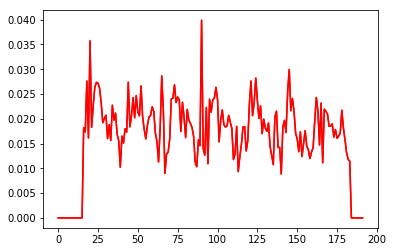

In [821]:
res = []

for i in range(17,25):
    maxnow = 0
    for j in range(0,24):
        if(len(data[(data['f16:day'] == i) & (data['f16:hour'] == j)]) != 0):
            now = data[(data['f16:day'] == i) & (data['f16:hour'] == j)]['label'].sum()/len(data[(data['f16:day'] == i) & (data['f16:hour'] == j)])
            res.append(now)
        else:
            now = 0
            res.append(0)
        if now > maxnow:
            maxnow = now
    print(str(i) + ' ' + str(j))
    
plt.plot(range(len(res)), res,'r', label='broadcast')
plt.plot(range(len(res)), res,'r', label='broadcast')

In [820]:
data.to_pickle('data/round1_train2')

if(flag is False):
    data_test.to_pickle('data/round1_test2')